In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import math
from tkinter import *
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
pd.options.mode.chained_assignment = None
from sklearn import metrics

<h1>Load Dataset</h1>

In [3]:
df = pd.read_csv("Dataset/ParkingData_Month_Time_Week.csv")

In [4]:
data = df[['Latitude','Longitude','count','Day_Num','Issue Month','Time_Num','Street Name']]

In [5]:
#Bounding Box for New York State
min_lon =-79.762152
max_lon =-71.856214
min_lat =40.496103
max_lat =45.01585

<h1> KNN Model </h1>

Gives the cluster value of target location and tells if its safe to park or not. If not safe, Also gives the top three areas to avoid for parking. 

In [6]:
def knnModel(lat,lon,clustered_x):
    #print(lat,lon)
    x = clustered_x[['Latitude','Longitude']]
    y = clustered_x['cluster']
    
    #train Model
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors = 3)
    # Fit the classifier to the data
    knn.fit(x_train,y_train)
    #show first 5 model predictions on the test data
    #knn.predict(x_test)[0:5]
    
    score = knn.score(x_test, y_test)
    print("KNN Score", score)
    
#     #train model with cv of 5 
#     cv_scores = cross_val_score(knn, x, y, cv=5)
#     #print each cv score (accuracy) and average them
#     #print(cv_scores)
#     print('Cross Validation Score Mean:{}'.format(np.mean(cv_scores)))

    #for given query
    x_coord,y_coord=lat,lon
    case_coords= [x_coord,y_coord]
    case_cluster = knn.predict(np.array(case_coords).reshape(1,-1))
    if(case_cluster[0]!=-1):
        distances,indices = knn.kneighbors(np.array(case_coords).reshape(1,-1))
        if(min(distances[0])>1):
            print("Safe to Park")
            label_out_0 = Label(root, text="Safe To Park")
            label_out_0.place(x=190,y=670)
            
        else:
            print("Not safe to park!!!")
            print("Also Avoid the following areas:")
            label_out_0 = Label(root, text="Not safe to park!!! Also Avoid the following areas:")
            label_out_0.place(x=150,y=670)
            num=20
            for i in indices[0]:
                print(np.array(clustered_x['street name'])[i])
                var = 'label_out'+str(num)
                var = Label(root, text = np.array(clustered_x['street name'])[i] )
                var.place(x=200,y=670+num)
                num+=20
    else:
        print("Safe To Park")

<h1>DBSCAN Model </h1>

Performs DBSCAN clustering to get cluster values and calls KNN model for classification.

In [7]:
def dbscanCluster(values,sample):
    sample_x = sample[['Latitude','Longitude']]
    # get min pts value -- heuristic method
    min_pts = round(math.log(sample.shape[0]))
    print("Min Pts Value",min_pts)
    #build dbscan model for sample_x
    m = DBSCAN(eps=0.5, min_samples=min_pts)
    m.fit(sample_x)
    #get cluster labels
    clusters = m.labels_
    print("Cluster Labels",set(clusters))
    #count number of clusters -1 means outlier
    n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
    print("number of clusters = ",n_clusters_)
    #Silhoutte Score
    print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(sample_x, clusters))
    #plotting clusters
    colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    plt.scatter(sample_x.iloc[:,0], sample_x.iloc[:,1], c=vectorizer(clusters))
    plt.title("DBSCAN Clusters")     #rendered after GUI is closed
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    #add clusters column
    clustered_x = sample_x
    clustered_x['cluster']=clusters
    clustered_x['street name']=sample['Street Name']
    #print(clustered_x.head())
    
    #Call KNN Model
    knnModel(values[0],values[1],clustered_x)
    

Function to filter based on Month, Day and Time user input. It calls DBSCAN Model

In [8]:
def processing(values):
    #select sample based on month,day,time
    sample= data[(data['Day_Num']==values[3]) & (data['Issue Month']==values[2]) & (data['Time_Num']==values[4])]
    #print(sample.head(2))
    #print(sample.shape)
    plt.scatter(sample['Latitude'],sample['Longitude'])
    dbscanCluster(values,sample)
    

Function to extract values from GUI input

In [9]:
def getValues():
    m = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    d = {'Mon':0,'Tue':1,'Wed':2,'Thurs':3,'Fri':4,'Sat':5,'Sun':6}
    t = {"12AM-6AM":0,"6AM-12PM":1,"12PM-6PM":2,"6PM-12AM":3}
    lat = float(entry_1.get())
    lon = float(entry_2.get())
    month = str((listbox_1.get(ACTIVE)))
    day = str((listbox_2.get(ACTIVE)))
    time = str((listbox_3.get(ACTIVE)))
    #print(lat,lon,month,day,time)
    #print(lat,lon,m[month],d[day],t[time])
    if((lat>=min_lat) & (lat<=max_lat) & (lon>=min_lon) & (lon<=max_lon)):
        processing((lat,lon,m[month],d[day],t[time]))
    else:
        print("Coordinates outside the State of New York")
        label_out_10 = Label(root, text="Coordinates outside the State of New York")
        label_out_10.place(x=190,y=670)
        
    

<h1> GUI Entry </h1>

Min Pts Value 9
Cluster Labels {0, 1, 2, -1}
number of clusters =  3
Silhouette Coefficient: 0.943
KNN Score 0.998274374460742
Not safe to park!!!
Also Avoid the following areas:
E 20th St
WB GOETHALS RD N @ J
E 233rd St


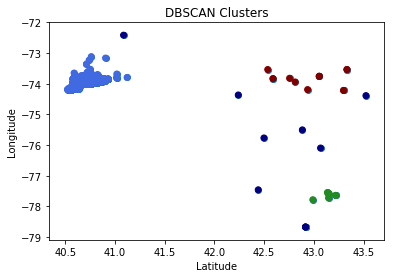

In [12]:
root = Tk()
root.geometry('500x760')
root.title("Check Parking")

#Lat & Lon
label_0 = Label(root, text="Check Parking",width=20,font=("bold", 20))
label_0.place(x=90,y=53)

label_1 = Label(root, text="Latitude",width=20,font=("bold", 10))
label_1.place(x=80,y=130)
entry_1 = Entry(root)
entry_1.place(x=240,y=130)


label_2 = Label(root, text="Longitude",width=20,font=("bold", 10))
label_2.place(x=68,y=180)
entry_2 = Entry(root)
entry_2.place(x=240,y=180)

#Month
label_3 = Label(root, text="Month",width=20,font=("bold", 10))
label_3.place(x=40,y=230)
# entry_3 = Entry(root)
# entry_3.place(x=140,y=230)
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
listbox_1 = Listbox(root,exportselection=0)
for item in months:
    listbox_1.insert(END, item)
listbox_1.place(x=60, y=250)

#Day
label_4 = Label(root, text="Day",width=20,font=("bold", 10))
label_4.place(x=280,y=230)
# entry_4 = Entry(root)
# entry_4.place(x=240,y=230)
days=['Mon','Tue','Wed','Thurs','Fri','Sat','Sun']
listbox_2 = Listbox(root,exportselection=0)
for item in days:
    listbox_2.insert(END, item)
listbox_2.place(x=300, y=250)

#Time Slot
label_5 = Label(root, text="Time Slot",width=20,font=("bold", 10))
label_5.place(x=70,y=440)
listbox_3 = Listbox(root,exportselection=0)  
listbox_3.insert(1,"12AM-6AM")  
listbox_3.insert(2, "6AM-12PM")  
listbox_3.insert(3, "12PM-6PM")  
listbox_3.insert(4, "6PM-12AM")  
listbox_3.place(x=200, y=440)

Button(root, text='Submit',width=20,bg='brown',fg='white',command=getValues).place(x=180,y=630)
# it is use for display the registration form on the window


root.mainloop()

In [11]:
40.732670, -74.001725

(40.73267, -74.001725)